In [3]:
# Cell 1: Imports & Settings
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    roc_curve, roc_auc_score
)


In [4]:
# Cell 2: Load Data, Filter to Final Statuses, Map Target & Grade
df = pd.read_csv("accepted_2007_to_2018Q4.csv")  # adjust path as needed

# Keep only completed loans
df = df[df['loan_status'].isin(['Fully Paid','Charged Off'])]

# Binary target: 0 = Fully Paid, 1 = Charged Off
df['target'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

# Convert letter grades A–G to numeric 0–6
grade_map = {g: i for i, g in enumerate(['A','B','C','D','E','F','G'])}
df['grade'] = df['grade'].map(grade_map)


<ipython-input-4-dc7764332c0f>:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("accepted_2007_to_2018Q4.csv")  # adjust path as needed


In [5]:
# Cell 3: DTI ↔ Default Correlation & Summary Stats
corr = df['dti'].corr(df['target'])
print(f"Point-biserial correlation (DTI vs. default): {corr:.3f}\n")
print("DTI summary by loan outcome:")
print(df.groupby('loan_status')['dti'].describe())


Point-biserial correlation (DTI vs. default): 0.099

DTI summary by loan outcome:
               count       mean        std  min    25%    50%     75%     max
loan_status                                                                  
Charged Off   4625.0  21.310554   8.900710  0.0  14.75  21.34  28.110   59.26
Fully Paid   17951.0  18.629848  11.376221  0.0  12.09  17.97  24.625  999.00


<Figure size 640x480 with 0 Axes>

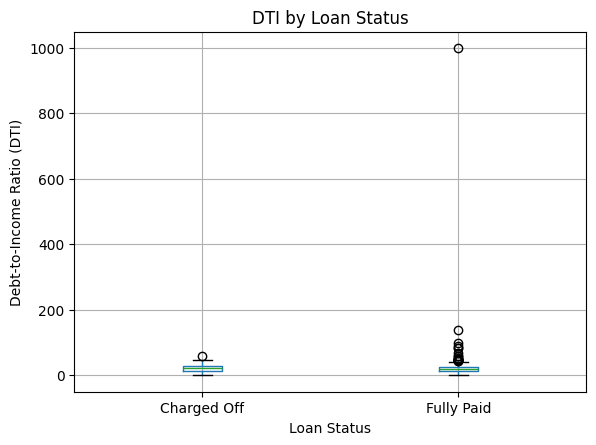

In [6]:
# Cell 4: Boxplot of DTI by Loan Status
plt.figure()
df.boxplot(column='dti', by='loan_status')
plt.title('DTI by Loan Status')
plt.suptitle('')
plt.xlabel('Loan Status')
plt.ylabel('Debt-to-Income Ratio (DTI)')
plt.show()


In [9]:
# Cell 5: Prepare Features & Train/Test Split (DTI + Grade)

fs = df[['dti','grade','target']].dropna()
X = fs[['dti','grade']]
y = fs['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print("Train set:", X_train.shape, "Test set:", X_test.shape)


Train set: (18060, 2) Test set: (4516, 2)


In [10]:
# Cell 6: Logistic Regression on DTI + Grade
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print("=== Logistic Regression ===")
print("Accuracy: ", accuracy_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Paid','Charged Off']))

# Coefficients
coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': lr.coef_[0]
})
print("\nCoefficients:\n", coef_df)


=== Logistic Regression ===
Accuracy:  0.6645261293179805
F1-score: 0.43023693117713424

Classification Report:
              precision    recall  f1-score   support

        Paid       0.87      0.68      0.76      3591
 Charged Off       0.33      0.62      0.43       925

    accuracy                           0.66      4516
   macro avg       0.60      0.65      0.60      4516
weighted avg       0.76      0.66      0.69      4516


Coefficients:
   feature  coefficient
0     dti     0.021695
1   grade     0.599277


In [12]:
# Cell 7: MLPClassifier on DTI + Grade
mlp = MLPClassifier(
    hidden_layer_sizes=(16,8),
    activation='relu',
    solver='adam',
    max_iter=100,
    random_state=42,

)
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
print("=== MLPClassifier ===")
print("Accuracy: ", accuracy_score(y_test, y_pred_mlp))
print("F1-score:", f1_score(y_test, y_pred_mlp))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=['Paid','Charged Off']))


=== MLPClassifier ===
Accuracy:  0.7922940655447298
F1-score: 0.17137809187279152

Classification Report:
              precision    recall  f1-score   support

        Paid       0.81      0.97      0.88      3591
 Charged Off       0.47      0.10      0.17       925

    accuracy                           0.79      4516
   macro avg       0.64      0.54      0.53      4516
weighted avg       0.74      0.79      0.74      4516



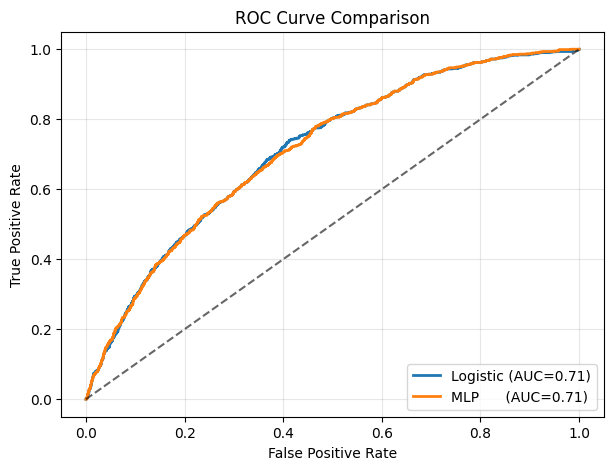

In [13]:
# Cell 8: ROC Curve Comparison
y_prob_lr  = lr.predict_proba(X_test)[:,1]
y_prob_mlp = mlp.predict_proba(X_test)[:,1]

fpr_lr,  tpr_lr,  _ = roc_curve(y_test, y_prob_lr)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr,  tpr_lr,  label=f"Logistic (AUC={roc_auc_score(y_test, y_prob_lr):.2f})", linewidth=2)
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP      (AUC={roc_auc_score(y_test, y_prob_mlp):.2f})", linewidth=2)
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


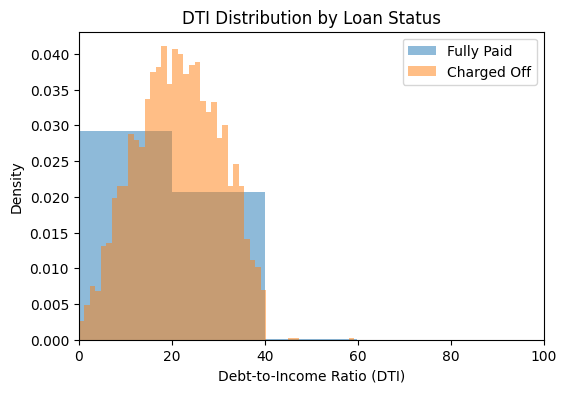

In [14]:
# Cell 9: DTI Distribution Histogram
paid    = df[df['target']==0]['dti']
charged = df[df['target']==1]['dti']

plt.figure(figsize=(6,4))
plt.hist(paid,    bins=50, alpha=0.5, label='Fully Paid',  density=True)
plt.hist(charged, bins=50, alpha=0.5, label='Charged Off', density=True)
plt.xlim(0,100)
plt.xlabel('Debt-to-Income Ratio (DTI)')
plt.ylabel('Density')
plt.title('DTI Distribution by Loan Status')
plt.legend()
plt.show()
